In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt

import ccxt

In [2]:
hyperliquid = ccxt.hyperliquid()
markets = hyperliquid.load_markets()

In [4]:
filters = {
    'swap': True,
    'active': True,
}

volume_limit = 100

perp_markets = []
usd_volume_1d = {}
open_interest = {}
mid_px = {}
max_leverage = {}
for symbol, details in markets.items():
    fits_filters = True
    for k, v in filters.items():
        if details.get(k) != v:
            fits_filters = False
            break
    if fits_filters:
        perp_markets.append({symbol: details})
        usd_volume_1d[symbol.replace('/USDC:USDC', '')] = details['info']['dayNtlVlm']
        open_interest[symbol.replace('/USDC:USDC', '')] = details['info']['openInterest']
        mid_px[symbol.replace('/USDC:USDC', '')] = details['info']['midPx']
        max_leverage[symbol.replace('/USDC:USDC', '')] = details['info']['maxLeverage']

liquidity_df = pd.DataFrame({
    'usd_volume_1d': usd_volume_1d,
    'open_interest': open_interest,
    'mid_px': mid_px,  
    'max_leverage': max_leverage,
}).astype(float).sort_values(by='usd_volume_1d', ascending=False)

liquidity_df['usd_volume_1d'] = liquidity_df['usd_volume_1d'] / 1_000_000
liquidity_df['open_interest_usd'] = liquidity_df['open_interest'] * liquidity_df['mid_px'] / 1_000_000
#liquidity_df.sort_values(by='open_interest_usd', ascending=False, inplace=True)
#liquidity_df.head(30) / 1_000_000

volume_thresh = 5 
open_int_thresh = 10

symbols = liquidity_df.query(
    f'open_interest_usd > {open_int_thresh} and usd_volume_1d > {volume_thresh} and max_leverage >= 5'
).index.tolist()
symbols = [symbol for symbol in symbols if symbol != 'BERA']
(liquidity_df.loc[symbols])[['usd_volume_1d', 'open_interest_usd', 'max_leverage']].T.round(1)

,BTC,ETH,SOL,FARTCOIN,HYPE,XRP,POPCAT,OM,SUI,kPEPE,TRUMP,ENA,ONDO,ADA,CRV,LINK,BNB,DOGE,AVAX,LDO
usd_volume_1d,2689.8,1059.3,649.5,163.6,105.6,83.5,48.2,40.8,29.5,26.7,19.2,16.0,9.8,8.7,8.5,7.7,7.6,7.3,6.7,5.8
open_interest_usd,1161.8,473.3,239.1,110.7,279.6,177.4,17.9,10.9,31.3,83.6,41.8,26.4,14.7,24.4,12.6,17.4,11.2,21.6,19.2,14.1
max_leverage,40.0,25.0,20.0,5.0,5.0,20.0,10.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0


In [504]:
def historical_funding_rate(ticker, start=None, end=None):
    #hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
    all_funding_rates = []
    while start < end:
        funding_rate_history = hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
        if not funding_rate_history:
            break
        all_funding_rates.extend(funding_rate_history)
        start = funding_rate_history[-1]['timestamp'] + 1  # Move start to the next timestamp

    result = {entry['timestamp']: entry['fundingRate'] for entry in all_funding_rates}
    return result


def historical_close_volume(ticker, start=None, end=None):
    all_data = []
    while start < end:
        ohlcv_data = hyperliquid.fetch_ohlcv(symbol=f"{ticker}/USDC:USDC", timeframe='1h', since=start, limit=500)
        if not ohlcv_data:
            break
        all_data.extend(ohlcv_data)
        start = ohlcv_data[-1][0] + 1  # Move start to the next timestamp

    result = {entry[0]: {'close': entry[4], 'volume': entry[5]} for entry in all_data}  # Extract timestamp, close price, and volume
    return result


def get_historical_data(ticker, start, end):
    funding_rate = historical_funding_rate(ticker, start, end)
    close_volume = historical_close_volume(ticker, start, end)

    df = pd.DataFrame({
        'funding': funding_rate,
        'close': {timestamp: data['close'] for timestamp, data in close_volume.items()},
        'volume': {timestamp: data['volume'] for timestamp, data in close_volume.items()},
    }).sort_index()
    df.index = pd.to_datetime(df.index, unit='ms', utc=True)
    df = df.resample('h').last()    
    return df

In [505]:
start = int((datetime.now() - timedelta(days=90)).timestamp() * 1000)
end = int(datetime.now().timestamp() * 1000)

bera_df = get_historical_data('BERA', start, end)
bera_df.head()

KeyboardInterrupt: 

In [ ]:
data = {}

start = int(bera_df.index[0].timestamp() * 1000)
for symbol in tqdm(symbols):
    data[symbol] = get_historical_data(symbol, start, end)

100%|██████████| 17/17 [02:16<00:00,  8.05s/it]


In [ ]:
funding_df = pd.DataFrame({k: df['funding'] for k, df in data.items()})
price_df = pd.DataFrame({k: df['close'] for k, df in data.items()})
volume_df = pd.DataFrame({k: df['volume'] for k, df in data.items()})
notional_df = price_df * volume_df

funding_df.head()
price_df.head()
notional_df.head()

,BTC,ETH,SOL,XRP,SUI,ADA,kPEPE,DOGE,AVAX,TRUMP,ENA,ONDO,LINK,AAVE,BNB,LTC,MKR
2025-02-06 13:00:00+00:00,8.714670e+07,6.265296e+07,1.009524e+07,3.834095e+06,8.740591e+06,200880.66455,7.577378e+05,5.799611e+05,270934.73035,2.896725e+06,9.226796e+05,1.142321e+06,3.203976e+05,2.373924e+05,767048.45040,393317.7800,10441.878125
2025-02-06 14:00:00+00:00,1.425022e+08,1.422917e+08,1.718506e+07,6.881587e+06,3.591087e+06,345844.72287,6.464409e+06,1.028652e+06,338711.48428,4.928216e+06,3.940922e+06,1.602541e+06,6.876619e+05,1.158075e+06,460528.80808,401348.0364,234122.852050
2025-02-06 15:00:00+00:00,1.354810e+08,2.006654e+08,4.503141e+07,1.211418e+07,1.173187e+07,806027.50644,5.653274e+06,2.611270e+06,896032.82052,7.340078e+06,2.844144e+06,9.580035e+06,1.879289e+06,2.452424e+06,206498.60055,259534.7992,293091.952104
2025-02-06 16:00:00+00:00,1.173435e+08,1.129502e+08,3.684929e+07,5.632255e+06,6.975594e+06,129315.49974,7.403519e+06,2.241826e+06,909347.55496,5.281595e+06,1.122675e+06,4.292530e+06,8.715841e+05,2.998520e+06,347939.60550,370778.8944,87537.730000
2025-02-06 17:00:00+00:00,1.099661e+08,3.712595e+07,2.937400e+07,1.117412e+07,6.643098e+06,248277.40608,2.872364e+06,3.136068e+06,544602.73816,4.538053e+06,1.461901e+06,1.874069e+06,3.159378e+05,5.686267e+05,81444.33764,99216.8892,298387.681632


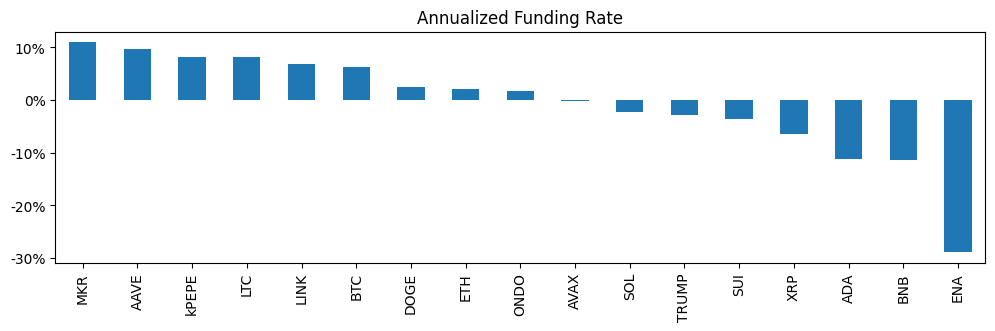

In [ ]:
from matplotlib.ticker import FuncFormatter

ax = (funding_df.mean() * 24 * 365 * 100).sort_values(ascending=False).plot.bar(figsize=(12, 3), title='Annualized Funding Rate')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

In [ ]:
start = '2025-02-15 13:00:00+00:00'

bera_returns = bera_df['close'].loc[start:].pct_change().dropna()
asset_returns = price_df.loc[start:].pct_change().dropna()
bera_returns, asset_returns = bera_returns.align(asset_returns, join='inner', axis=0)

mean_returns = asset_returns.mean()
cov_matrix = asset_returns.cov()

correlations = asset_returns.corrwith(bera_returns)

pd.DataFrame({
    'corr since 2/15/25': correlations.sort_values(ascending=False)
}).T.style.format("{:.1%}")


,ONDO,DOGE,ETH,LINK,SUI,AAVE,AVAX,kPEPE,BTC,BNB,SOL,XRP,LTC,ENA,TRUMP,MKR,ADA
corr since 2/15/25,55.5%,55.4%,55.3%,55.2%,53.7%,53.6%,53.2%,52.7%,51.3%,50.8%,50.6%,47.2%,46.9%,46.3%,46.1%,40.4%,35.3%


In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

n_components = 5
pca = PCA(n_components=n_components)
pca_scores = pca.fit_transform(asset_returns)

pc1 = pca.transform(asset_returns)[:, 0]

explained_variance = []
for i in range(n_components):
    pc = pca_scores[:, i].reshape(-1, 1)
    model = LinearRegression().fit(pc, bera_returns)
    r2 = model.score(pc, bera_returns)
    explained_variance.append(r2 * 100)  # percent

# Step 4: Output results
for i, r2 in enumerate(explained_variance, start=1):
    print(f"PC{i} explains {r2:.2f}% of BERA's return variation.")

pca = PCA(n_components=1)
pc1 = pca.fit_transform(asset_returns).flatten()

correlation = np.corrcoef(pc1, bera_returns.values)[0, 1]
print(f"Correlation between BERA returns and market component (PC1): {correlation:.3f}")

pc1_weights = pd.Series(
    pca.components_[0],
    index=asset_returns.columns,
    name='PC1 loading'
)
pca_market_portfolio = pc1_weights / pc1_weights.abs().sum()


PC1 explains 33.05% of BERA's return variation.
PC2 explains 2.80% of BERA's return variation.
PC3 explains 0.03% of BERA's return variation.
PC4 explains 1.01% of BERA's return variation.
PC5 explains 0.18% of BERA's return variation.
Correlation between BERA returns and market component (PC1): 0.575


In [ ]:
notional_df.mean() * 24 / 1_000_000

BTC      2811.484972
ETH      1418.565329
SOL       603.226617
XRP       177.936717
SUI        66.726643
ADA        30.975825
kPEPE      56.859994
DOGE       39.377225
AVAX       12.140638
TRUMP      38.218385
ENA        26.646786
ONDO       11.070331
LINK       18.243383
AAVE       22.385466
BNB        34.545495
LTC        21.018506
MKR        13.034552
dtype: float64

In [ ]:
import cvxpy as cp

funding_vector = -(funding_df[asset_returns.columns].mean() * 24 * 365).values

pca = PCA(n_components=1)  # you can tune this
pca_factors = pca.fit_transform(asset_returns)

# Step 2: Reconstruct returns using top components only
cleaned_returns = pca.inverse_transform(pca_factors)
cleaned_returns_df = pd.DataFrame(cleaned_returns, index=asset_returns.index, columns=asset_returns.columns)

# Align indices
bera_returns, asset_returns = bera_returns.align(cleaned_returns_df, join='inner', axis=0)

# Convert to numpy
R = asset_returns.values
r_bera = bera_returns.values
n_assets = R.shape[1]
w = cp.Variable(n_assets)

r_portfolio = R @ w

tracking_error = cp.sum_squares(r_portfolio - r_bera)
funding_penalty = funding_vector @ w  # linear penalty
lambda_funding = 0.0001 # you can tune this

objective = cp.Minimize(tracking_error + lambda_funding * funding_penalty)

constraints = [cp.sum(w) == 1, w >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

optimal_weights = pd.Series(w.value, index=asset_returns.columns)
optimal_weights = pd.Series(w.value, index=asset_returns.columns)
filtered_weights = optimal_weights[optimal_weights > 1e-3]  # filter threshold = 0.001

pd.DataFrame({
    'weights': filtered_weights,
    'funding rate (ann.)': -pd.Series(funding_vector, index=asset_returns.columns),
}).dropna().sort_values(by='weights', ascending=False).round(3).style.format("{:.1%}")
#filtered_weights.sort_values(ascending=False).round(3)

,weights,funding rate (ann.)
LTC,28.1%,8.1%
BTC,24.4%,6.3%
AAVE,23.8%,9.8%
MKR,11.4%,11.0%
LINK,5.5%,6.8%
kPEPE,5.3%,8.3%
ETH,1.5%,2.1%


<Axes: title={'center': '7-Day Rolling Correlation with BERA'}>

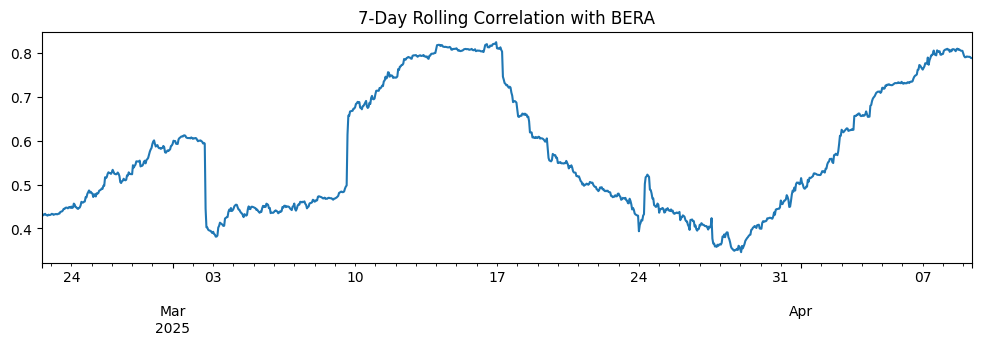

In [ ]:
# Recreate portfolio returns
tracked_returns = asset_returns.dot(optimal_weights)

tracked_returns.rolling(24*7).corr(bera_returns).dropna().plot(
    figsize=(12, 3), 
    title='7-Day Rolling Correlation with BERA'
)

Optimized correlation: 0.57488


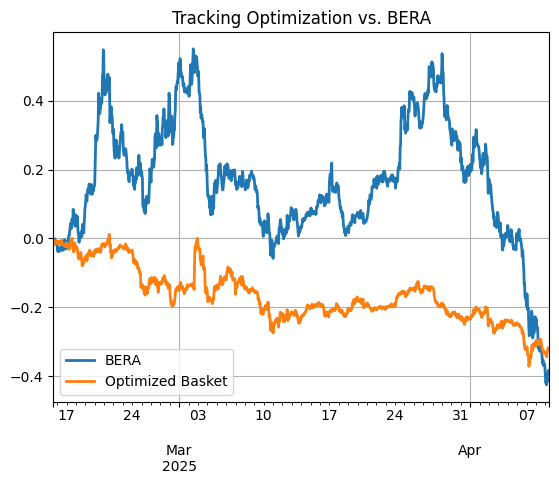

In [ ]:
# Recreate portfolio returns
tracked_returns = asset_returns.dot(optimal_weights)

# Correlation with BERA
correlation = tracked_returns.corr(bera_returns)
print(f"Optimized correlation: {correlation:.5f}")

# Optional: Plot cumulative returns
((1 + bera_returns).cumprod() - 1).plot(label="BERA", linewidth=2)
((1 + tracked_returns).cumprod() - 1).plot(label="Optimized Basket", linewidth=2)
plt.title("Tracking Optimization vs. BERA")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
funding_vector = -(funding_df[asset_returns.columns].mean() * 24 * 365).values

pca = PCA(n_components=1)  # you can tune this
pca_factors = pca.fit_transform(asset_returns)

# Step 2: Reconstruct returns using top components only
cleaned_returns = pca.inverse_transform(pca_factors)
cleaned_returns_df = pd.DataFrame(cleaned_returns, index=asset_returns.index, columns=asset_returns.columns)
residual_returns = asset_returns - cleaned_returns_df

# Align indices
bera_returns, residual_returns = bera_returns.align(residual_returns, join='inner', axis=0)
R = residual_returns.values
r_bera = bera_returns.values

n_assets = R.shape[1]
w = cp.Variable(n_assets)

r_portfolio = R @ w

tracking_error = cp.sum_squares(r_portfolio - r_bera)
funding_penalty = funding_vector @ w  # linear penalty
lambda_funding = 0.0001 # you can tune this

objective = cp.Minimize(tracking_error + lambda_funding * funding_penalty)

constraints = [cp.sum(w) == 1, w >= 0]

problem = cp.Problem(objective, constraints)
problem.solve()

optimal_weights = pd.Series(w.value, index=asset_returns.columns)
optimal_weights = pd.Series(w.value, index=asset_returns.columns)
filtered_weights = optimal_weights[optimal_weights > 1e-3]  # filter threshold = 0.001

pd.DataFrame({
    'weights': filtered_weights,
    'funding rate (ann.)': -pd.Series(funding_vector, index=asset_returns.columns),
}).dropna().sort_values(by='weights', ascending=False).round(3).style.format("{:.1%}")
#filtered_weights.sort_values(ascending=False).round(3)

,weights,funding rate (ann.)
MKR,77.8%,11.0%
AAVE,22.2%,9.8%


In [ ]:
# account for volume

daily_volume = notional_df.mean() * 24
basket_size = 5_000_000
max_pct_daily_volume = 0.05

# Compute max allowed notional per asset
max_allocation_usd = daily_volume * max_pct_daily_volume

# Convert to max weights relative to total basket size
max_weights = max_allocation_usd / basket_size

# Align and convert to numpy
max_weights = max_weights[asset_returns.columns].fillna(1.0)  # fallback to 100% if volume missing

funding_vector = -(funding_df[asset_returns.columns].mean() * 24 * 365).values

pca = PCA(n_components=1)  # you can tune this
pca_factors = pca.fit_transform(asset_returns)

# Step 2: Reconstruct returns using top components only
cleaned_returns = pca.inverse_transform(pca_factors)
cleaned_returns_df = pd.DataFrame(cleaned_returns, index=asset_returns.index, columns=asset_returns.columns)

# Align indices
bera_returns, asset_returns = bera_returns.align(cleaned_returns_df, join='inner', axis=0)

# Convert to numpy
R = asset_returns.values
r_bera = bera_returns.values
n_assets = R.shape[1]
w = cp.Variable(n_assets)

r_portfolio = R @ w

tracking_error = cp.sum_squares(r_portfolio - r_bera)
funding_penalty = funding_vector @ w  # linear penalty
lambda_funding = 0.0001 # you can tune this

objective = cp.Minimize(tracking_error + lambda_funding * funding_penalty)

constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= max_weights.values  # enforce volume constraint
]

problem = cp.Problem(objective, constraints)
problem.solve()

optimal_weights = pd.Series(w.value, index=asset_returns.columns)
optimal_weights = pd.Series(w.value, index=asset_returns.columns)
filtered_weights = optimal_weights[optimal_weights > 1e-3]  # filter threshold = 0.001

pd.DataFrame({
    'weights': filtered_weights,
    'funding rate (ann.)': -pd.Series(funding_vector, index=asset_returns.columns),
    'pct_daily_volume ($5m Basket)': (optimal_weights * basket_size) / daily_volume,
}).dropna().sort_values(by='weights', ascending=False).round(3).style.format("{:.1%}")


,weights,funding rate (ann.),pct_daily_volume ($5m Basket)
BTC,31.1%,6.3%,0.1%
AAVE,22.4%,9.8%,5.0%
LTC,21.0%,8.1%,5.0%
kPEPE,12.6%,8.3%,1.1%
MKR,7.2%,11.0%,2.8%
LINK,5.7%,6.8%,1.6%


<Axes: title={'center': '7-Day Rolling Correlation with BERA'}>

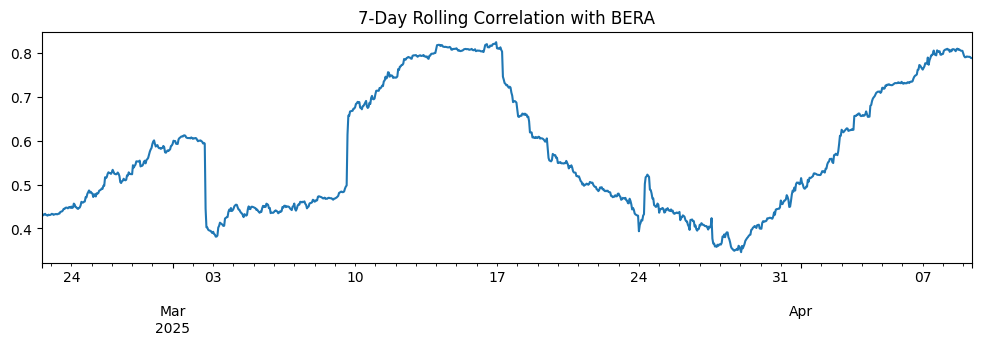

In [ ]:
# Recreate portfolio returns
tracked_returns = asset_returns.dot(optimal_weights)

tracked_returns.rolling(24*7).corr(bera_returns).dropna().plot(
    figsize=(12, 3), 
    title='7-Day Rolling Correlation with BERA'
)

In [ ]:
int(pd.to_datetime('2025-03-03 12:00:00+00:00').timestamp())*1000

1741003200000

In [ ]:
from basket import HedgeBasket

basket_dates = [
    '2025-03-03 12:00:00+00:00',
    '2025-03-10 12:00:00+00:00',
    '2025-03-17 12:00:00+00:00',
    '2025-03-24 12:00:00+00:00',
    '2025-03-31 12:00:00+00:00',
    '2025-04-07 12:00:00+00:00',
]

baskets = {
    dt: HedgeBasket(
        ticker='BERA',
        timestamp=int(pd.to_datetime(dt).timestamp())*1000,
        basket_size=5_000_000,
        max_pct_daily_volume=0.05,
        lambda_funding=0.1
    ) for dt in basket_dates
}

In [ ]:
weights = {}
for dt, basket in tqdm(baskets.items()):
    weights[dt] = basket.optimized_weights['weights']
    print(f"The correlation between the basket and BERA for {dt[:10]} is {basket.correlation:.2f}.")
    #print(weights[dt])

100%|██████████| 6/6 [00:00<00:00, 13699.41it/s]

The correlation between the basket and BERA for 2025-03-03 is 0.43.
The correlation between the basket and BERA for 2025-03-10 is 0.53.
The correlation between the basket and BERA for 2025-03-17 is 0.52.
The correlation between the basket and BERA for 2025-03-24 is 0.57.
The correlation between the basket and BERA for 2025-03-31 is 0.61.
The correlation between the basket and BERA for 2025-04-07 is 0.68.


In [ ]:
weights_df = pd.DataFrame(weights)

weights_clean = weights_df.fillna(0)
weights_clean.columns = pd.to_datetime(weights_df.columns).date
weights_clean.sort_values(by=weights_clean.columns[0], ascending=False).style.format("{:.1%}")

,2025-03-03,2025-03-10,2025-03-17,2025-03-24,2025-03-31,2025-04-07
BTC,45.7%,48.4%,48.8%,43.6%,16.7%,0.0%
AAVE,9.0%,9.4%,9.2%,9.1%,14.1%,19.1%
LTC,8.6%,9.1%,10.6%,13.9%,12.3%,8.4%
POPCAT,8.0%,7.9%,7.6%,7.2%,10.1%,12.3%
kPEPE,6.4%,5.5%,5.1%,6.9%,11.6%,20.2%
MKR,6.1%,6.0%,5.8%,5.4%,5.4%,6.7%
LDO,5.0%,4.8%,4.7%,6.2%,5.3%,4.7%
LINK,4.8%,4.5%,5.7%,6.0%,16.0%,18.2%
TRUMP,3.4%,2.8%,0.0%,0.0%,0.0%,0.0%
XRP,3.0%,1.6%,0.0%,0.0%,0.0%,0.0%


In [ ]:
pd.DataFrame({
    'In Sample Correlation to BERA': pd.Series({dt: basket.correlation for dt, basket in baskets.items()}),
    'Avg Annualized Funding Rate': pd.Series({
        dt: basket.optimized_weights['funding rate (ann.)'].dot(basket.optimized_weights['weights']) for dt, basket in baskets.items()
    }),
}).style.format("{:.1%}")

,In Sample Correlation to BERA,Avg Annualized Funding Rate
2025-03-03 12:00:00+00:00,43.3%,8.0%
2025-03-10 12:00:00+00:00,52.6%,8.0%
2025-03-17 12:00:00+00:00,52.2%,7.4%
2025-03-24 12:00:00+00:00,57.5%,6.6%
2025-03-31 12:00:00+00:00,61.2%,6.1%
2025-04-07 12:00:00+00:00,68.0%,7.0%


In [ ]:
import time

basket_assets = weights_df.index.to_list()

basket_asset_data = {}
data_start = int(pd.to_datetime(basket_dates[0]).timestamp())*1000
data_end = int(datetime.utcnow().timestamp()) * 1000
for symbol in tqdm(basket_assets):
    basket_asset_data[symbol] = get_historical_data(symbol, data_start, data_end)
    time.sleep(2)

basket_asset_funding = pd.DataFrame({symbol: data['funding'] for symbol, data in basket_asset_data.items()})
basket_asset_close = pd.DataFrame({symbol: data['close'] for symbol, data in basket_asset_data.items()})
basket_asset_returns = basket_asset_close.pct_change()
basket_asset_volume = pd.DataFrame({symbol: data['volume'] for symbol, data in basket_asset_data.items()})
basket_asset_volume_usd = basket_asset_volume * basket_asset_close

benchmark_returns = get_historical_data('BERA', data_start, data_end)

100%|██████████| 16/16 [01:55<00:00,  7.24s/it]


In [ ]:
basket_asset_funding.to_clipboard()

In [ ]:
correlation = {}
basket_returns = {}
volatilty = {}
benchmark_volatility = {}
for dt, basket in baskets.items():
    basket_returns[dt] = (basket.asset_returns[basket.optimized_weights.index] * basket.optimized_weights['weights']).sum(1)
    correlation[dt] = basket_returns[dt].corr(basket.benchmark_returns)
    volatilty[dt] = basket_returns[dt].std() * np.sqrt(24 * 365)
    benchmark_volatility[dt] = basket.benchmark_returns.std() * np.sqrt(24 * 365)
    #print(f"The correlation between the basket and BERA for {dt[:10]} is {correlation[dt]:.2f}.")

pd.DataFrame({
    'In Sample Correlation to BERA': pd.Series({dt: correlation[dt] for dt, basket in baskets.items()}),
    'Avg Annualized Funding Rate': pd.Series({
        dt: basket.optimized_weights['funding rate (ann.)'].dot(basket.optimized_weights['weights']) for dt, basket in baskets.items()
    }),
    'Basket Volatility': pd.Series(volatilty),
    'Benchmark Volatility': pd.Series(benchmark_volatility),
}).to_clipboard()#.style.format("{:.1%}")


In [537]:
#pnl_data = pd.read_clipboard(index_col=0)


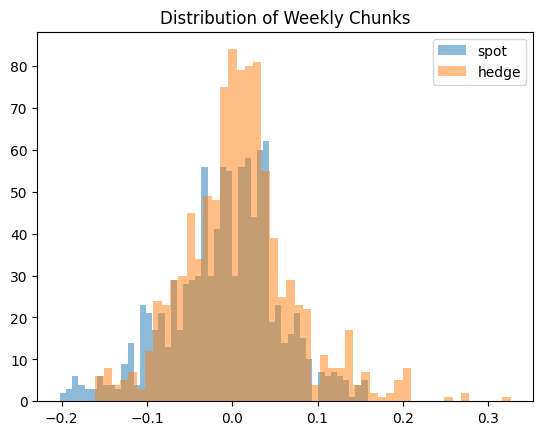

In [588]:
chunk_size = 24*7  # 7-day chunks
spot_array = (pnl_data['spot_pnl'] / 3_000_000).values
hedge_array = (pnl_data['hedge_pnl'] / 3_000_000).values

max_start = len(spot_array) - chunk_size + 1  # +1 to include last possible chunk

# Rolling chunks
spot_chunks = [spot_array[i:i+chunk_size].sum() for i in range(max_start)]
hedge_chunks = [hedge_array[i:i+chunk_size].sum() for i in range(max_start)]

spot_chunks = np.array(spot_chunks)
hedge_chunks = np.array(hedge_chunks)

n_sims = 10000
chunks_per_year = 52  # using daily chunks

spot_annual = []
hedge_annual = []
combined_annual = []

for _ in range(n_sims):
    idx = np.random.randint(0, len(spot_chunks), size=chunks_per_year)
    spot_sample = spot_chunks[idx]
    hedge_sample = hedge_chunks[idx]
    
    spot_return = np.prod(1 + spot_sample) - 1
    hedge_return = np.prod(1 + hedge_sample) - 1
    combined_return = np.prod(1 + (spot_sample + hedge_sample)) - 1

    spot_annual.append(spot_return)
    hedge_annual.append(hedge_return)
    combined_annual.append(combined_return)

spot_annual = np.array(spot_annual)
hedge_annual = np.array(hedge_annual)
combined_annual = np.array(combined_annual)

# Summary percentiles
pct_levels = [.99, .95, .9, .75, .5, .25, .1, .05, .01]

summary_df = pd.DataFrame({
    'percentile': pct_levels,
    'combined': np.percentile(combined_annual, [p * 100 for p in pct_levels]),
    #$'spot_only': np.percentile(spot_annual, [p * 100 for p in pct_levels]),
    #'hedge_only': np.percentile(hedge_annual, [p * 100 for p in pct_levels]),
})

summary_df.to_clipboard(index=False)
summary_df.style.format("{:.1%}")

,percentile,combined
0,99.0%,820.3%
1,95.0%,401.3%
2,90.0%,266.6%
3,75.0%,116.3%
4,50.0%,18.1%
5,25.0%,-34.3%
6,10.0%,-63.0%
7,5.0%,-73.7%
8,1.0%,-85.6%


NameError: name 'combined_chunks' is not defined

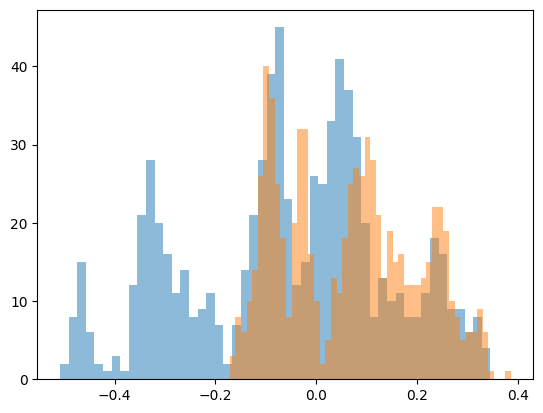

In [589]:
plt.hist(spot_chunks, bins=50, alpha=0.5, label='spot')
plt.hist(hedge_chunks, bins=50, alpha=0.5, label='hedge')
plt.hist(combined_chunks, bins=50, alpha=0.5, label='combined')
plt.legend()
plt.title("Distribution of Weekly Returns")
plt.show()